# COMPUTATIONAL EFFICIENCY RESULTS

In [1]:

from data import UKDALEData
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from modelGen import modelGen
from address import get_model_path
%matplotlib inline



2023-12-14 13:42:26.940188: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
dataGen = UKDALEData(path="./data/")
trainMain,trainTargets, trainStates = dataGen.get_train_sequences(houses = 1,
                                                                  start = "2015-01-01",
                                                                  end="2016-01-01")
testMain,testTargets, testStates = dataGen.get_test_sequences(houses = 1,
                                                              start = "2016-01-01",
                                                              end="2016-02-01",
                                                              norm=False)


data= {"X_train":trainMain,
        "Y_train":trainTargets,
        "Y_states":trainStates,
        "Z_train":trainStates,
        "X_test":testMain,
        "Y_test":testTargets,
        "Z_test":testStates,
        "app_data":dataGen.get_app_data(),
        "main_data": dataGen.get_main_mean_std()
        } 

Loading the models

In [3]:

%%capture
MODELSID = ["dAE","biLSTM","FCNdAE","multiUNET","multiFCNdAE"]
SEQ_LEN = [100,500,1440]
APP_LABELS = list(data["app_data"].keys())
MODELS = []
WEIGHTS = []
TIMES   = []
n = 10 # Number of inferences to compute the averaged inference time


for seq in SEQ_LEN:
    w = []
    t = []
    for modelID in MODELSID:
        MODELS.append(modelGen(modelID=modelID,data=data, params = {"sequence_length":seq}))
        # weights
        w.append(MODELS[-1].get_num_weights())
        # inference times
        X_random = np.random.rand(10*60*5) #1 day of data
        t.append(MODELS[-1].get_inference_time(X_random,n))


    WEIGHTS.append(w)
    TIMES.append(t)

#for ii,modelID in enumerate(MODELSID):
#    print(f"nº trainable weights {modelID}: {WEIGHTS[ii]}")



2023-12-14 13:43:14.818951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 13:43:15.067389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22311 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
2023-12-14 13:43:15.742179: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-12-14 13:43:16.460783: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [4]:
WEIGHTS = np.array(WEIGHTS)
TIMES   = np.array(TIMES)
MODELSLABELS = ["dAE","biLSTM","FCNdAE","U-Net","multi-FCNdAE"]
df_weights = pd.DataFrame(WEIGHTS.T,columns=SEQ_LEN,index =MODELSLABELS)/1e6
df_weights = df_weights.loc[["dAE","FCNdAE","multi-FCNdAE","U-Net","biLSTM"]]

df_times   = pd.DataFrame(TIMES.T,columns=SEQ_LEN,index =MODELSLABELS)
df_times   = df_times.loc[["dAE","FCNdAE","multi-FCNdAE","U-Net","biLSTM"]]
df_times   = df_times # miliseconds

In [88]:
df_w = pd.melt(df_weights,ignore_index=False,value_name="weigths")
df_w = df_w.reset_index()
df_w.columns = ["model","Seq. length","weights"]
df_w['model'] = df_w['model'].astype("category")

df_w

,model,Seq. length,weights
0,dAE,100,4.233005
1,FCNdAE,100,0.246925
2,multi-FCNdAE,100,0.292121
3,U-Net,100,2.556962
4,biLSTM,100,6.324885
5,dAE,500,85.161005
6,FCNdAE,500,1.000925
7,multi-FCNdAE,500,0.692521
8,U-Net,500,2.556962
9,biLSTM,500,6.324885


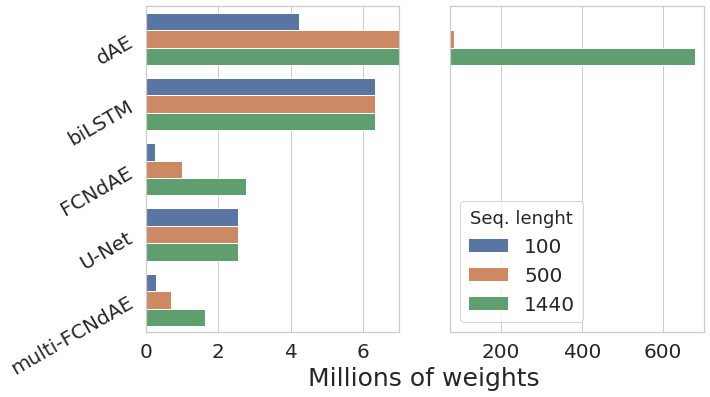

In [108]:


import seaborn as sns

# Your existing code
colors = ['purple', 'orange', 'green']


plot_order = df_w.sort_values('weights', ascending=False)['model'].unique()

f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1,figsize=(10,6))


ax1 = sns.barplot(x="weights", y="model",
                  hue="Seq. length", data=df_w,order=plot_order,ax=ax1)
ax2 = sns.barplot(x="weights", y="model",
                  hue="Seq. length", data=df_w,order=plot_order, ax=ax2)
ax1.set_xlim(0,7)
ax2.set_xlim(75,700)

ax2.get_yaxis().set_visible(False)
# ax = df_weights.plot.barh(grid=True,
#                           color=colors,
#                           figsize=(10, 6))

ax1.set_ylabel("")

ax1.set_xlabel("")
ax2.set_xlabel("")

ax1.tick_params("y", labelsize=20,rotation=30)
ax1.tick_params("x", labelsize=20)
ax2.tick_params("x", labelsize=20)
# ax.tick_params("y", labelrotation=45, labelsize=25)
f.text( 0.35,0.02, "Millions of weights ",fontdict={"fontsize":25}, va="center", rotation="horizontal")
ax1.get_legend().remove()
ax2.legend(fontsize=20,title="Seq. lenght",title_fontsize=18)




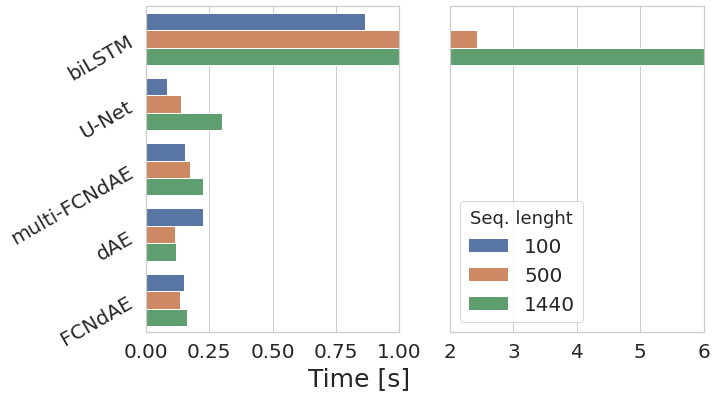

In [109]:
df_t = pd.melt(df_times,ignore_index=False,value_name="times")
df_t = df_t.reset_index()
df_t.columns = ["model","Seq. length","times"]
df_t['model'] = df_t['model'].astype("category")


plot_order = df_t.sort_values('times', ascending=False)['model'].unique()

f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1,figsize=(10,6))


ax1 = sns.barplot(x="times", y="model",
                  hue="Seq. length", data=df_t,order=plot_order,ax=ax1)
ax2 = sns.barplot(x="times", y="model",
                  hue="Seq. length", data=df_t,order=plot_order, ax=ax2)
ax1.set_xlim(0,1)
ax2.set_xlim(2,6)

ax2.get_yaxis().set_visible(False)
# ax = df_weights.plot.barh(grid=True,
#                           color=colors,
#                           figsize=(10, 6))

ax1.set_ylabel("")

ax1.set_xlabel("")
ax2.set_xlabel("")

ax1.tick_params("y", labelsize=20,rotation=30)
ax1.tick_params("x", labelsize=20)
ax2.tick_params("x", labelsize=20)
# ax.tick_params("y", labelrotation=45, labelsize=25)
f.text( 0.35,0.02, "Time [s] ",fontdict={"fontsize":25}, va="center", rotation="horizontal")
ax1.get_legend().remove()
ax2.legend(fontsize=20,title="Seq. lenght",title_fontsize=18)

